# Building an SER Emotion Classifier!

In this project, we aim to build a SER emotion classifier using the TESS dataset provided by the University of Toronto!

Our goal is to:
1. Retrieve Data
2. Explore Data
3. Augment Data
4. Process Data
5. Extract Features
6. Train Model
7. Test Model

In [1]:
#%pip install seaborn
#%pip install librosa
#%pip install kagglehub
#%pip install pandas
#%pip install matplotlib

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense,
    Bidirectional, LSTM, Reshape, Permute, Multiply, Lambda, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import tensorflow as tf
tf.debugging.set_log_device_placement(True) # TURNED ON FOR GPU STUFF YOU CAN TURN THIS OFF
from IPython.display import Audio
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import kagglehub


In [14]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# import tensorflow as tf
# print("GPUs available:", tf.config.list_physical_devices('GPU'))

## Retrieving the Data

In [2]:
# download the dataset
tess_path = os.path.expanduser("~/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess")
if not os.path.exists(tess_path):
    kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", tess_path)

Path to dataset files: C:\Users\IO/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess


In [3]:
emotions = []
file_paths = []

for root, dirs, files in os.walk(tess_path):
    for file in files:
        if file.endswith('.wav'):
            emotion = os.path.basename(root) # take base name as emotion
            emotions.append(emotion)
            file_paths.append(os.path.join(root, file))

data_df = pd.DataFrame({
    'Emotion': emotions,
    'File_Path': file_paths
})
print(data_df['Emotion'].unique())

# remove oaf and yaf
data_df['Emotion'] = data_df['Emotion'].apply(lambda label: label.lower().split('_')[1] if '_' in label else label)

print(data_df['Emotion'].unique())

['OAF_angry' 'OAF_disgust' 'OAF_Fear' 'OAF_happy' 'OAF_neutral'
 'OAF_Pleasant_surprise' 'OAF_Sad' 'YAF_angry' 'YAF_disgust' 'YAF_fear'
 'YAF_happy' 'YAF_neutral' 'YAF_pleasant_surprised' 'YAF_sad']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'pleasant' 'sad']


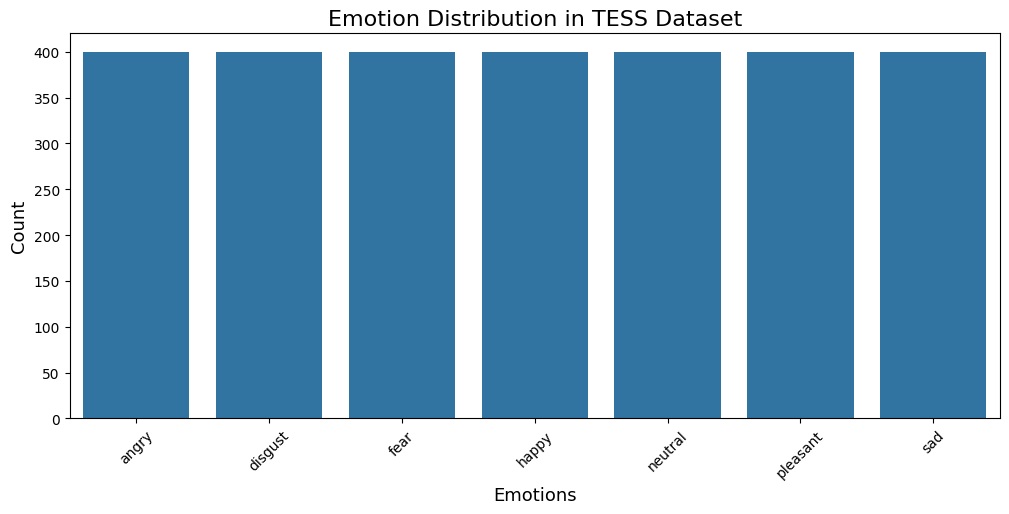

In [4]:
# emotion distribution!
plt.figure(figsize=(12, 5))
sns.countplot(data=data_df, x='Emotion', order=data_df['Emotion'].value_counts().index)
plt.title('Emotion Distribution in TESS Dataset', fontsize=16) # big font
plt.xlabel('Emotions', fontsize=13) # bigger font for clarity
plt.ylabel('Count', fontsize=13) # bigger font for clarity
plt.xticks(rotation=45) # rotate them since the words are long
plt.show()

## Data Exploration!

Here, we understand and explore the TESS dataset.

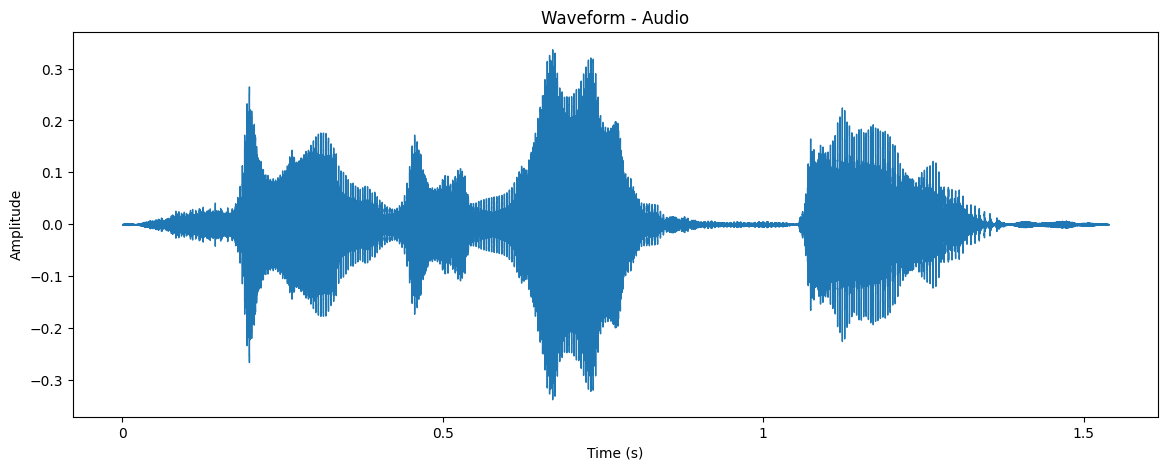

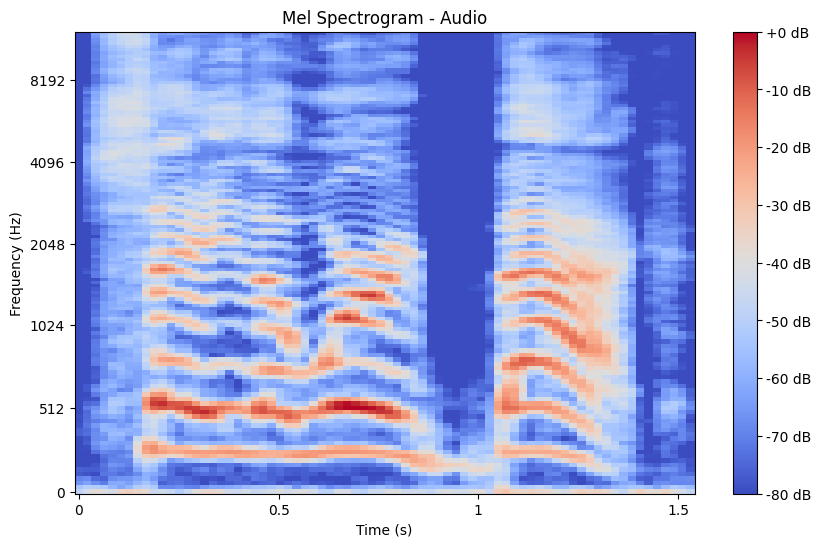

In [5]:
def load_audio(file_path):
    data, sr = librosa.load(file_path, sr=None) # audio with original sample
    return data, sr

def visualize_and_play(data, sr, title="Audio", size=(14,5)):
    """
    Visualize the waveform and play the audio.
    """
    plt.figure(figsize=size)
    plt.title(f"Waveform - {title}")
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    return Audio(data, rate=sr)

def plot_spectrogram(data, sr, title="Audio", size=(10, 6)):
    """
    Plot the mel spectrogram from audio data.
    """
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=size)
    plt.title(f"Mel Spectrogram - {title}")
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

original_data, sr = load_audio(data_df.loc[0, 'File_Path'])
audio_player = visualize_and_play(original_data, sr)
plot_spectrogram(original_data, sr)
audio_player

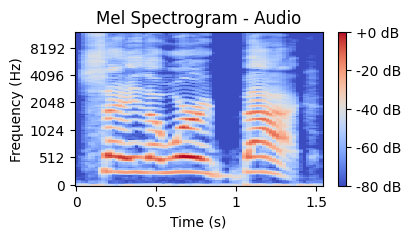

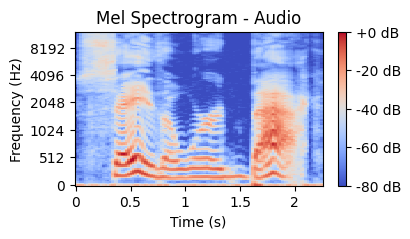

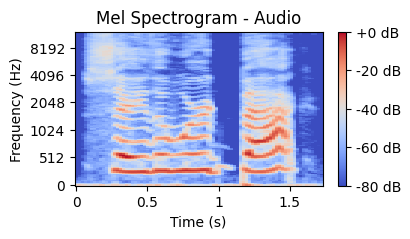

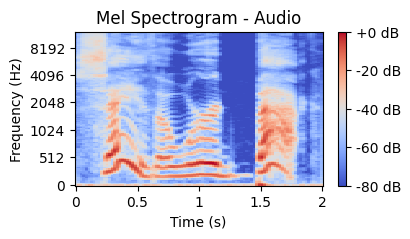

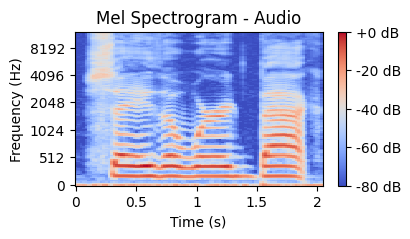

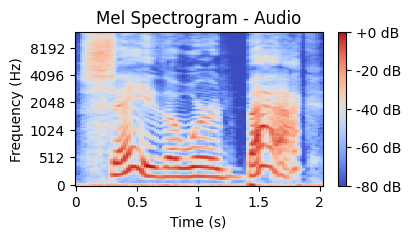

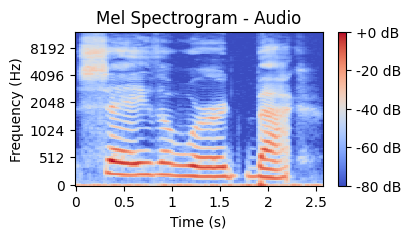

In [6]:
unique_emotions = data_df['Emotion'].unique()
for emotion in unique_emotions:
    sample_file = data_df[data_df['Emotion'] == emotion].iloc[0]['File_Path']
    original_data, sr = load_audio(sample_file)
    plot_spectrogram(original_data, sr, size=(4,2))

## Data Augmentation

Since our dataset is quite small in size, we will use data augmentation strategies to help increase diversity.

We will implement:
1. Noise Injection
2. Time Stretching
3. Pitch Shifting

We add elements of randomness to the augmentation, while also keeping a boundary to help better improve generalization

However, this may come at a big cost during preprocessing, and whether or not we will use it is still unknown.

In [7]:
def noise(data, noise_factor_range=(0.01, 0.05)):
    noise_factor = np.random.uniform(*noise_factor_range)  # randomness in noise
    noise_amp = noise_factor * np.max(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate_range=(0.8, 1.2)):
    rate = np.random.uniform(*rate_range)  # random stretching
    while rate == 1:  # if we get 1, make sure there is.
        rate = np.random.uniform(*rate_range)
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sr, n_steps_range=(-4, 4)):
    n_steps = np.random.randint(*n_steps_range)  # random shifting of pitch
    while n_steps == 0: #if no pitch change, ensure it
        n_steps = np.random.randint(*n_steps_range)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)


In [8]:
def augment_audio(data, sr):
    augmented_data = [data]
    augmented_data.append(noise(data))
    augmented_data.append(stretch(data))
    augmented_data.append(pitch(data, sr))
    return augmented_data

Playing: Original


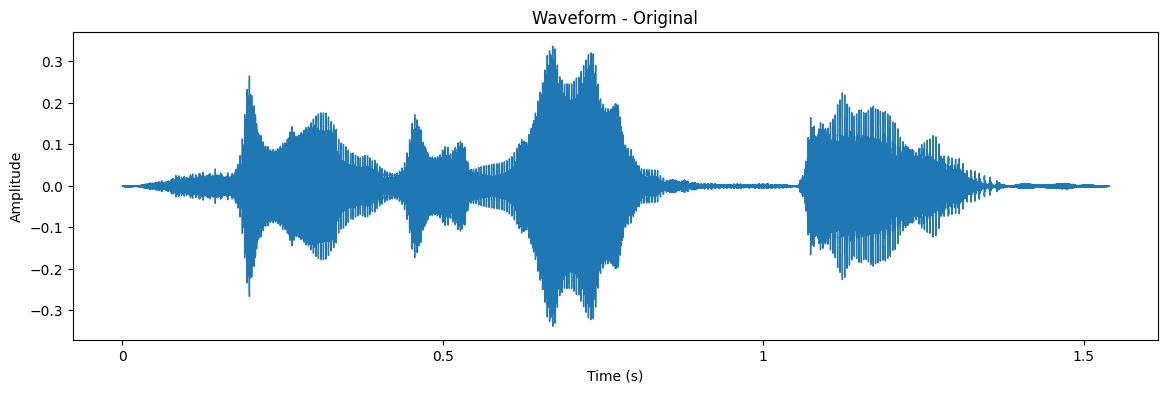

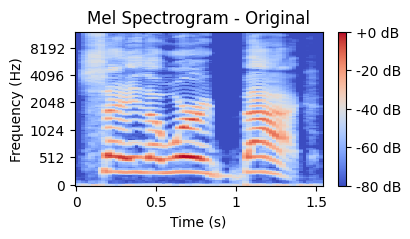

Playing: Noise Added


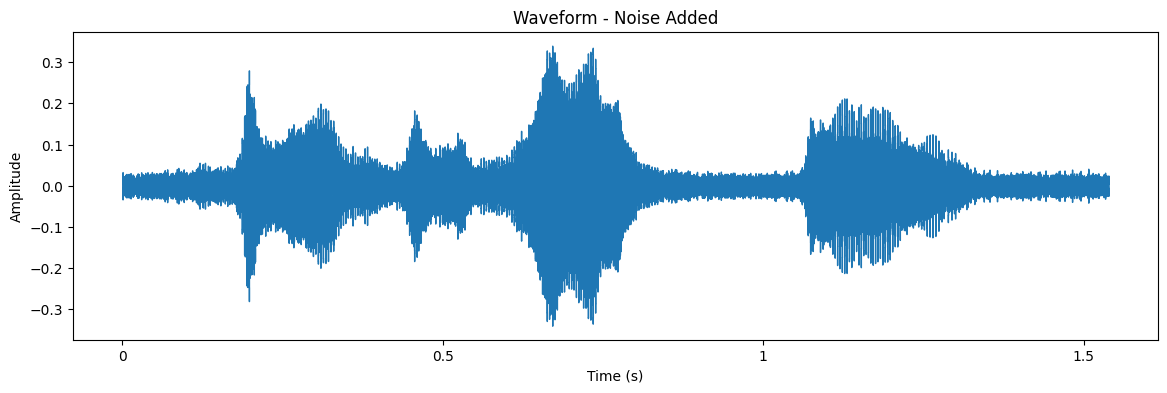

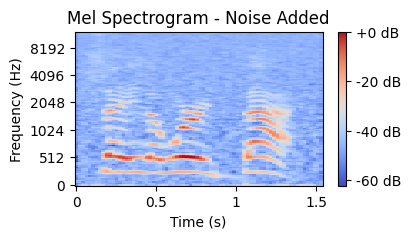

Playing: Time Stretched


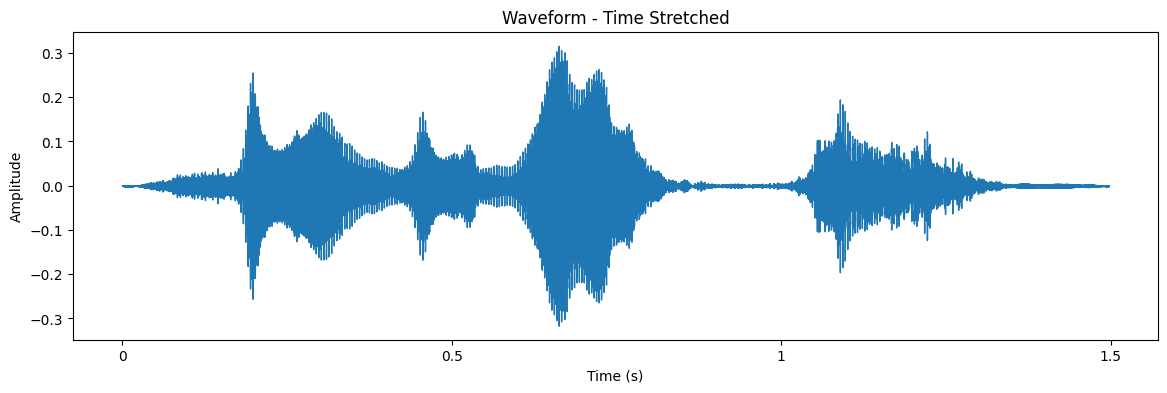

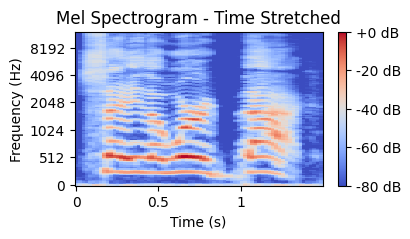

Playing: Pitch Shifted


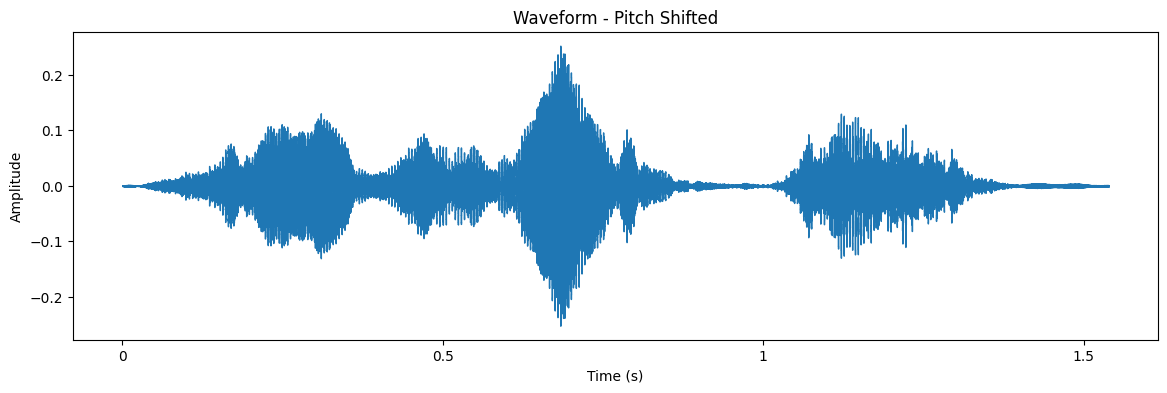

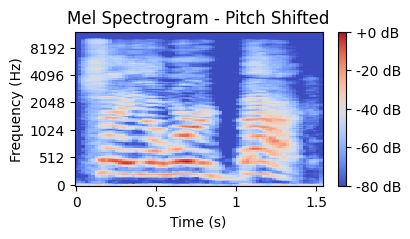

In [9]:
sample_file = data_df.loc[0, 'File_Path']
original_data, sr = load_audio(sample_file)

augmented_versions = augment_audio(original_data, sr)
titles = ["Original", "Noise Added", "Time Stretched", "Pitch Shifted"]

for i, augmented_data in enumerate(augmented_versions):
    print(f"Playing: {titles[i]}")
    audio_player = visualize_and_play(augmented_data, sr, title=titles[i], size=(14,4))
    display(audio_player)
    plot_spectrogram(augmented_data, sr, title=titles[i], size=(4,2))

In [10]:
def augment_dataset(data_df):
    """
    augment entire dataset by applying augmentation to each audio file.
    """
    augmented_audio = []
    emotions = []

    for _, row in data_df.iterrows():
        file_path = row['File_Path']
        emotion = row['Emotion']
        raw_data, sr = load_audio(file_path)
        # augment
        augmented_versions = augment_audio(raw_data, sr)
        
        # add to dataset
        for augmented_data in augmented_versions:
            augmented_audio.append(augmented_data)
            emotions.append(emotion)  # Same label for all augmented versions

    return augmented_audio, emotions, sr

augmented_audio, augmented_emotions, sr = augment_dataset(data_df)
augmented_data_df = pd.DataFrame({
    'Emotion': augmented_emotions,
    'Audio_Data': augmented_audio
})
data_df['Audio_Data'] = data_df['File_Path'].apply(lambda path: load_audio(path)[0])
full_data_df = pd.concat([data_df[['Emotion', 'Audio_Data']], augmented_data_df], ignore_index=True)
print(full_data_df.head())
print(f"Total samples in combined dataset: {len(full_data_df)}")

  Emotion                                         Audio_Data
0   angry  [0.0, -0.00018310547, -0.0002746582, -0.000244...
1   angry  [0.0, -9.1552734e-05, -9.1552734e-05, -0.00018...
2   angry  [0.0, 3.0517578e-05, 6.1035156e-05, 3.0517578e...
3   angry  [0.0, -0.00015258789, -0.00015258789, -3.05175...
4   angry  [0.0, -3.0517578e-05, -3.0517578e-05, -0.00030...
Total samples in combined dataset: 14000


## Audio Preprocessing

Now, we need to do 4 main things.
1. Resample the audio to 16k
2. Remove silence segments
3. Keep a fixed duration
4. Normalize the Amplitude

In [11]:
def preprocess_audio(data, sr, target_sr=16000, duration=2.5):
    # resample ti 16k
    if sr != target_sr:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sr)
    
    # trim silence
    data, _ = librosa.effects.trim(data)

    # normalize amp
    data = librosa.util.normalize(data)

    # pad/truncate
    max_length = int(target_sr * duration)
    if len(data) > max_length:
        data = data[:max_length]  # Truncate
    else:
        data = np.pad(data, (0, max_length - len(data)))  # Pad

    return data, target_sr

Original


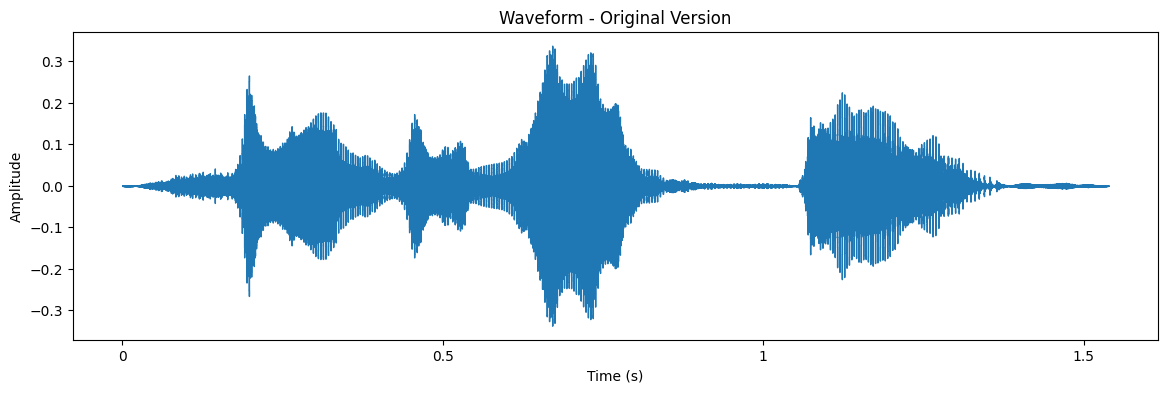

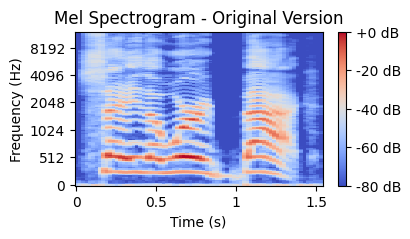

Preprocessed


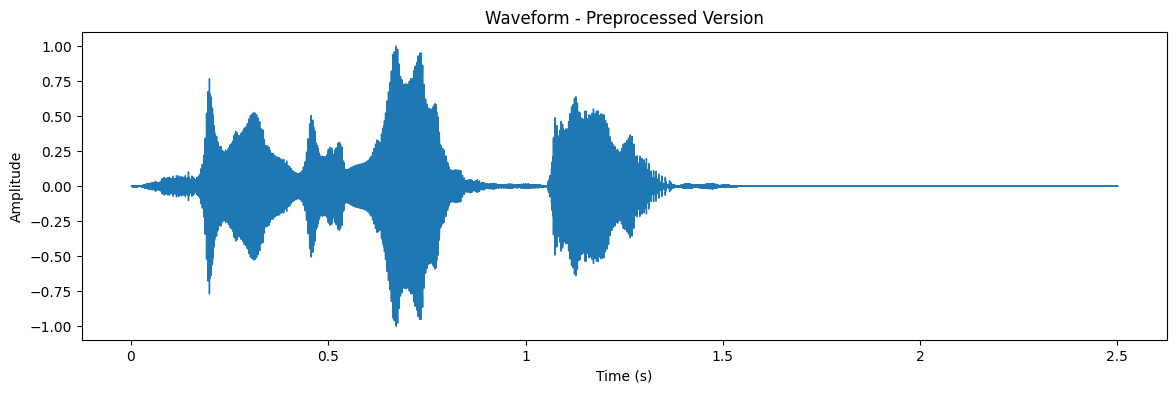

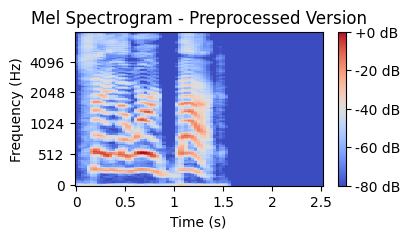

In [12]:
sample_file = data_df.loc[0, 'File_Path']
original_data, sr = load_audio(sample_file)

print("Original")
audio_player = visualize_and_play(original_data, sr, title="Original Version", size=(14,4))
display(audio_player)
plot_spectrogram(original_data, sr, title="Original Version", size=(4,2))

preprocessed_version, sr = preprocess_audio(original_data, sr)

print("Preprocessed")
audio_player = visualize_and_play(preprocessed_version, sr, title="Preprocessed Version", size=(14,4))
display(audio_player)
plot_spectrogram(preprocessed_version, sr, title="Preprocessed Version", size=(4,2))

In [13]:
def preprocess_dataset(data_df, target_sr=16000, duration=2.5, batch_size=500):
    """
    preprocess the dataset in batch_size.
    """
    preprocessed_audio = []
    for start in range(0, len(data_df), batch_size):
        batch = data_df.iloc[start:start + batch_size]
        for audio_data in batch['Audio_Data']:
            processed_audio, _ = preprocess_audio(audio_data, sr=target_sr, target_sr=target_sr, duration=duration)
            preprocessed_audio.append(processed_audio)
    return np.array(preprocessed_audio)


X_preprocessed = preprocess_dataset(full_data_df, target_sr=16000, duration=2.5)
y = full_data_df['Emotion']


In [14]:
print("X_preprocessed:")
display(X_preprocessed)
print("y:")
display(y)

X_preprocessed:


array([[ 0.00000000e+00, -5.42789930e-04, -8.14184896e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -5.19840571e-04, -5.19840571e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.15154304e-04,  2.30308608e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.97138836e-02, -2.33111490e-03,  9.81050490e-03, ...,
         2.39345631e-02,  7.10857763e-03,  4.34572767e-03],
       [ 1.46313035e-03,  1.95574190e-04,  7.84604927e-04, ...,
        -1.66682705e-01, -1.56208292e-01, -1.54519200e-01],
       [ 1.34868338e-03,  2.07823497e-04,  1.42114749e-03, ...,
        -1.39104836e-02, -7.00174551e-03, -2.17356603e-03]])

y:


0        angry
1        angry
2        angry
3        angry
4        angry
         ...  
13995      sad
13996      sad
13997      sad
13998      sad
13999      sad
Name: Emotion, Length: 14000, dtype: object

In [ ]:
#Run optionally
#np.save('X_preprocessed.npy', X_preprocessed)
#np.save('y_labels.npy', y)

# load preprocessed data when needed
#X_preprocessed = np.load('X_preprocessed.npy')
#y = np.load('y_labels.npy', allow_pickle=True)

## Extracting Features

In [15]:
def extract_mel_spectrogram(data, sr=16000, n_mels=128, fmax=8000, hop_length=512):
    """convert audio to mel-spec
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

X_features = np.array([extract_mel_spectrogram(data, sr=16000) for data in X_preprocessed])

In [16]:
X_features.shape

(14000, 128, 79)

In [17]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

y_onehot.shape

(14000, 7)

In [18]:
display(data_df.shape)
display(full_data_df.shape)
display(X_preprocessed.shape)

(2800, 3)

(14000, 2)

(14000, 40000)

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_features, y_onehot, test_size=0.2, stratify=y_onehot, random_state=42
)

# Then, split training+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Add the channel dimension for CNN input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

display(X_train.shape)
display(X_val.shape)
display(X_test.shape)


(8960, 128, 79, 1)

(2240, 128, 79, 1)

(2800, 128, 79, 1)

## Building the Model
The model we want to build is a Convolutional Recurrent Neural Network that uses bidirectional LSTM as well as an attention mechanism (or a CNN for mel-spec images, still unsure!)

This is just to explore options.

In [ ]:
def attention_mechanism(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = Flatten()(attention) 
    attention = Activation('softmax')(attention)
    attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)
    weighted_inputs = Multiply()([inputs, attention])
    return weighted_inputs

# 3. Build the Model
input_shape = (128, 79, 1)
inputs = Input(shape=input_shape)

# Convolutional Layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Reshape((x.shape[1], -1))(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

x = attention_mechanism(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")